In [1]:
### using (7.64a), which f0*\bar{v*} + \bar{v'q'} equal m (v* mean vTEM)
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm
from scipy.fftpack import fft,ifft,fftfreq
from scipy.interpolate import interp1d
from EOF import EOF
from scipy.fft import fft, ifft
import datetime 
from scipy import interpolate


In [3]:
from Dycore import Dycore
def read_all_var(pr_start, pr_to, pr_leap, start, end, internal_day, total_file):
        total_pr = int((pr_to - pr_start) / pr_leap)
        total_day = int(total_file*internal_day)
        
        qv      = np.zeros(((((total_pr, total_day, 20, 64, 128)))))
        qv_diff = np.zeros(((((total_pr, total_day, 20, 64, 128)))))
        u       = np.zeros(((((total_pr, total_day, 20, 64, 128)))))
        v       = np.zeros(((((total_pr, total_day, 20, 64, 128)))))
        t       = np.zeros(((((total_pr, total_day, 20, 64, 128)))))
        p       = np.zeros(((((total_pr, total_day, 20, 64, 128)))))
        ps      = np.zeros(((((total_pr, total_day, 20, 64, 128)))))
        p_half  = np.zeros(((((total_pr, total_day, 21, 64, 128)))))
        
        a = 0
        for pr in range(pr_start, pr_to, pr_leap):
            k = 0
            for day in range(start,end,internal_day):
                print(day)
                file  = f"HSt42_{pr}/RH80_PR{pr}_1600day_startfrom_{day}day_final.dat"
                dycore = Dycore(file)
                
                qv[a,k*100:(k+1)*100,:,:,:]      = dycore.qv
                qv_diff[a,k*100:(k+1)*100,:,:,:] = dycore.qv_diff
                u[a,k*100:(k+1)*100,:,:,:]       = dycore.u
                v[a,k*100:(k+1)*100,:,:,:]       = dycore.v
                t[a,k*100:(k+1)*100,:,:,:]       = dycore.t
                
                ps[a,k*100:(k+1)*100,:,:,:]      = dycore.ps
                p[a,k*100:(k+1)*100,:,:,:]       = dycore.p
                
                p_half[a,k*100:(k+1)*100,:,:,:]  = dycore.p_half
                            
                k += 1
            a += 1
        return qv, qv_diff, u, v, t, p, ps, p_half

In [4]:
pr_start = 0
pr_leap = 10
pr_to = 60
total_pr = (pr_to - pr_start) / pr_leap

start = 500
end   = 1600
internal_day = 100
total_day = int((end -start)/internal_day) * internal_day

total_file = int((end - start) / internal_day)
file  = "HSt42_0/RH80_PR0_1600day_startfrom_0day_final.dat"

# dycore = Dycore(file)
qv, qv_diff, u, v, t, p, ps, p_half = read_all_var(pr_start, pr_to, pr_leap, start , end, internal_day, total_file)  # 
print("done")


500
600
700
800
900
1000
1100
1200
1300
1400
1500
500
600
700
800
900
1000
1100
1200
1300
1400
1500
500
600
700
800
900
1000
1100
1200
1300
1400
1500
500
600
700
800
900
1000
1100
1200
1300
1400
1500
500
600
700
800
900
1000
1100
1200
1300
1400
1500
500
600
700
800
900
1000
1100
1200
1300
1400
1500
done


In [5]:
# file  = "800day_HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

# dycore = Dycore(file)
#
u  = u[1]  # dycore.getVar("grid_u_c_xyzt")
v  = v[1]  # dycore.getVar("grid_v_c_xyzt")
t  = t[1]  # dycore.getVar("grid_t_c_xyzt")
ps = ps[1] # dycore.getVar("grid_ps_xyzt")
p  = p[1]  # dycore.getVar("grid_p_full_xyzt")
sigma       = p / ps
sigma_mean  = np.nanmean(sigma, axis=(0,3))
sigma_onlyz = np.nanmean(sigma_mean, axis=1)
Rd = 287
cp = 1004
g  = 9.81
H  = 6800
a  = 6.37122e6
theta      = t * (ps / p)**(Rd/cp)
day = int(np.size(u[:,0,0,0]))

#
x = np.linspace(-180,180,128)
y = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)
#
f0  = 2 * 7.292E-5 * np.sin(yd)
# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy = np.cos(yd)
cy [0] = np.nan
cy [-1] = np.nan
#
### try to calculate balanced partial u partial t, which is calculated by TEM equation.
# first calculate zonal (v'q') (q is potential vorticity)
# zonal mean
Vzm     = np.nanmean(v, axis=3)
Uzm     = np.nanmean(u, axis=3)
THzm    = np.nanmean(theta, axis=3)
Pzm     = np.nanmean(p, axis=3)
Tzm     = np.nanmean(t, axis=3)
# time mean
Vzmtm   = np.nanmean(Vzm, axis=0)
Uzmtm   = np.nanmean(Uzm, axis=0)
THzmtm  = np.nanmean(THzm, axis=0)
Pzmtm   = np.nanmean(Pzm, axis=0)
Tzmtm   = np.nanmean(Tzm, axis=0)

Vza     = np.zeros(u.shape)
Uza     = np.zeros(u.shape)
THETAza = np.zeros(u.shape)
Pza     = np.zeros(u.shape)
Tza     = np.zeros(t.shape)

for i in range(0,128):
    Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
    Uza[:,:,:,i]     = u[:,:,:,i] - Uzm
    THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
    Pza[:,:,:,i]     = p[:,:,:,i] - Pzm
    Tza[:,:,:,i]     = t[:,:,:,i] - Tzm

M   = Uza * Vza
Mzm = np.nanmean(M, axis=(3))
for i in range(1,64-1):
    Mzm[:,:,i] = cy[i]**0.5 * Mzm[:,:,i]

dmdy = np.zeros(((day,20,64)))
for i in range(1,64-1):
    dmdy[:,:,i] = -(Mzm[:,:,i+1] - Mzm[:,:,i-1]) / (a * (yd[i+1] - yd[i-1]))
dmdy[:,:, 0] = -(Mzm[:,:, 1] - Mzm[:,:, 0]) / (a*(yd[ 1] - yd[ 0]))
dmdy[:,:,-1] = -(Mzm[:,:,-1] - Mzm[:,:,-2]) / (a*(yd[-1] - yd[-2]))
#
sigma_mean      = np.nanmean(p/ps, axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
#
# for i in range
# first mean y, then do three loop
bza =  THETAza / np.nanmean(theta, axis=0) * 9.81
print(day)
print("over")

1100
over


In [6]:
### ex z, ex theta, check plot z and theta, then cal N_square
# do ex z
start = datetime.datetime.now()
N_square   = np.zeros(((day,20,64,128)))
z = np.zeros(u.shape)
for i in range(1,20-1):
    z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])
##########
# print(z[0])
z_new     = np.zeros((((day,22,64,128))))
theta_new = np.zeros((((day,22,64,128))))

for i in range(day):
    for j in range(64):
          for k in range(128):
            fe            = interp1d(np.linspace(0,20,20),z[i,:,j,k],  fill_value='extrapolate')
            z_new[i,:,j,k] = fe(np.linspace(-1,21,22))
            fe            = interp1d(np.linspace(0,20,20),theta[i,:,j,k],  fill_value='extrapolate')
            theta_new[i,:,j,k] = fe(np.linspace(-1,21,22))
print("over")
end = datetime.datetime.now()
time = end - start
print(time)    

over
0:09:28.085671


In [7]:
# N^2
for i in range(1,20-1):
    N_square[:,i,:,:]   = 9.81 / theta[:,i,:,:] * (theta[:,i+1,:,:] - theta[:,i-1,:,:]) / (z[:,i+1,:,:]-z[:,i-1,:,:]) # original is partial z, but Dycore is on pressure (sigma) coord. so add minus
N_square[:, 0,:,:] = 9.81 / theta_new[:, 1,:] * (theta_new[:, 2,:] - theta_new[:, 0,:]) / (z_new[:,2,:,:]-z_new[:,0,:,:])
N_square[:,19,:,:] = 9.81 / theta_new[:,21,:,:] * (theta_new[:,21,:,:] - theta_new[:,18,:,:]) / (z_new[:,21,:,:]-z_new[:,18,:,:])

In [8]:
### edited for EOF, changing the dimension to (day, 20, 64) to do baroclinc annular mode
# MHF = np.nanmean(Vza * bza, axis=(0,3)) / np.nanmean(N_square, axis=(0,3))
MHF = np.nanmean(Vza * bza, axis=3) / np.nanmean(N_square, axis=3)

MHF_f  = np.zeros(MHF.shape) # mean meridional heat flux 
for i in range(64):
    MHF_f[:,:,i] = MHF[:,:,i] * f0[i]

In [9]:
### edited for EOF, changing the dimension to (day, 20, 64) to do baroclinc annular mode
z = np.zeros(u.shape)
for i in range(1,20-1):
    z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])

q2 = np.zeros(((day,20,64)))
for i in range(1,20-1):
    q2[:,i,:] = (MHF_f[:,i+1,:] - MHF_f[:,i-1,:])  / np.nanmean(z[:,i+1,:,:]-z[:,i-1,:,:], axis=(0,2)) 
MHF_f_new = np.zeros(((day,22,64)))

for i in range(day):
    for j in range(64):
        fe             = interp1d(np.linspace(0,20,20), MHF_f[i,:,j],  fill_value='extrapolate')
        MHF_f_new[i,:,j] = fe(np.linspace(-1,21,22))

# q2[ 0,:] = (MHF_f_new[ 2,:] - MHF_f_new[ 0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(0,2)) 
# q2[19,:] = (MHF_f_new[21,:] - MHF_f_new[19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(0,2)) 
#
# q2[q2 == inf] = np.nan
vq_final = q2 + dmdy
vq_final_reshape = np.reshape(vq_final,(day,20*64))

vq_final_mean  = np.nanmean(vq_final_reshape, axis=0)
vq_final_minus = vq_final_reshape - vq_final_mean
#
z = np.zeros(u.shape)
print(np.arange(-1,21))
for i in range(1,20-1):
    z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
z[:, 0,:,:] = Rd*np.nanmean(t[:,0:1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])

# MHF_new = np.zeros(((day,22,64)))

# for i in range(day):
#     for j in range(64):
#         fe             = interp1d(np.linspace(0,20,20), MHF[i,:,j],  fill_value='extrapolate')
#         MHF_new[i,:,j] = fe(np.linspace(-1,21,22))

VHF = np.zeros(((day,20,64))) # vertical heat flux
for i in range(1,20-1):
    VHF[:,i,:] = (MHF[:,i+1,:] - MHF[:,i-1,:])  / np.nanmean(z[:,i+1,:,:]-z[:,i-1,:,:], axis=(2)) 
# VHF[ :,0,:] = (MHF_new[ :,2,:] - MHF_new[ :,0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(2)) 
# VHF[:,19,:] = (MHF_new[:,21,:] - MHF_new[:,19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(2)) 

v_star = np.nanmean(v, axis=3) - VHF
print("over")

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
over


(1100,)


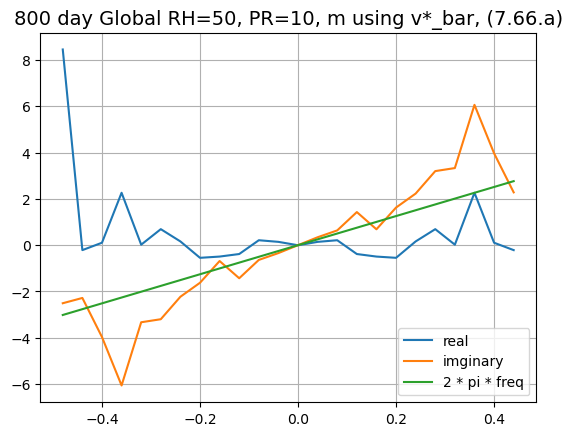

In [10]:
# Before EOF, we need to normalize final_m_term
u_50   = u # dycore.getVar("grid_u_c_xyzt")
u_50_w = np.zeros(u_50.shape)
for i in range(1,64-1): # cy[0] and [-1] are np.nan
    u_50_w[:,:,i,:] = u_50[:,:,i,:] * (cy[i])**0.5
u_50_w2   = np.nanmean(u_50_w[:,:,:,:], axis=(3))
u_50_new  = np.reshape(u_50_w2, (day, 20*64))
# print(u_50_new.shape)
###################################################


single_EOF_50 =  EOF((u_50_new,), n_components=640, field="1D")
single_EOF_50.get()

z_paper       = (single_EOF_50.PC[0,:])
EOF_try       = (single_EOF_50.EOF[0,:])

z_paper_std   = z_paper.std()
z_paper_final = z_paper / z_paper_std 
print(z_paper_final.shape)
# plot for check whether I got correct EOF and PC, 
# so I project(do dot) EOF on PC to test if I would go back to original u wind.

EOF_std = EOF_try.std()
EOF_try = EOF_try * z_paper_std 
EOF_back = np.reshape(EOF_try, (20,64))

f0v_star = np.zeros(((day,20,64)))
for i in range(64):
    f0v_star[:,:,i] = v_star[:,:,i] * f0[i]
f0v_star_reshape = np.reshape(f0v_star, (day,20*64))
f0v_star_minus   = f0v_star_reshape - np.nanmean(f0v_star_reshape, axis=0)
m_right = f0v_star_reshape + vq_final_reshape
m_right_final = m_right - np.nanmean(m_right, axis=0)

m = np.zeros(day)
for i in range(day):
    m[i] = np.nansum(EOF_try[2:-2]*m_right_final[i,2:-2].T)

m_std   = m.std()
m_final = m / m_std

# Do not take the all time series to do FFT,
# there would be offset. So I'm gotta to take the small time interval to do FFT, 
# which are overlap (because after FFT, there would be a pulse at both ends of the spectrum space.
lg      = 25 # length of interval 
Z_sum   = np.zeros(lg, dtype = complex)
M_sum   = np.zeros(lg, dtype = complex)

for i in range(0 , len(z), lg):
    if i == 0:
        aa = i
        Z_sum += fft(z_paper_final[0:aa+lg])  / len(z_paper_final[0:aa+lg])     #要除以資料長度
        M_sum += fft(m_final[0:aa+lg])  / len(m_final[0:aa+lg])
    else:
        aa = int(i-12)   
        Z_sum += fft(z_paper_final[aa:aa+lg]) / len(z_paper_final[aa:aa+lg])    #要除以資料長度
        M_sum += fft(m_final[aa:aa+lg]) / len(m_final[aa:aa+lg])
        # print(np.nanmin(Z_sum))

# print((len(Z) / lg))
Z = Z_sum / (len(z_paper) / lg)
M = M_sum / (len(m) / lg)
# print(Z_final)

freq   = fftfreq(Z.shape[0])
idx    = np.argsort(freq)

M_star = np.conjugate(M)
Z_star = np.conjugate(Z)

final  = (Z_star * M) / (Z_star * Z)

kk     = -1  #int(lg)
ll     = 0   #int(lg/2-2)
plt.figure(dpi=100.)
plt.title("800 day Global RH=50, PR=10, m using v*_bar, (7.66.a)", fontsize=14)
plt.plot(freq[idx][ll:kk], (final[idx][ll:kk]).real / np.pi, label="real")
plt.plot(freq[idx][ll:kk], (final[idx][ll:kk]).imag / np.pi, label="imginary")
plt.plot(freq[idx][ll:kk], (freq[idx][ll:kk]) * 2 * np.pi, label="2 * pi * freq")

# plt.xlim([-0.25, 0.25])
# plt.ylim([-3,3])
plt.grid()
plt.legend()
# plt.savefig(r"paper1_fig/eq(7.66a)_fig/RH50_PR10//800day_Global_v*_cross_spectrum.png", bbox_inches='tight', dpi=600.)
plt.show()

In [11]:
### do SM
### edited for EOF, changing the dimension to (day, 20, 64) to do baroclinc annular mode

q2_sm = np.zeros(((day,20,32)))
for i in range(1,20-1):
    q2_sm[:,i,:] = (MHF_f[:,i+1,:32] - MHF_f[:,i-1,:32])  / np.nanmean(z[:,i+1,:32,:]-z[:,i-1,:32,:], axis=(0,2)) 
MHF_f_new = np.zeros(((day,22,64)))

for i in range(day):
    for j in range(32):
        fe             = interp1d(np.linspace(0,20,20), MHF_f[i,:,j],  fill_value='extrapolate')
        MHF_f_new[i,:,j] = fe(np.linspace(-1,21,22))

# q2[ 0,:] = (MHF_f_new[ 2,:] - MHF_f_new[ 0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(0,2)) 
# q2[19,:] = (MHF_f_new[21,:] - MHF_f_new[19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(0,2)) 
#
# q2[q2 == inf] = np.nan
vq_final_sm = q2_sm + dmdy[:,:,:32]
vq_final_sm_reshape = np.reshape(vq_final_sm,(day,20*32))

vq_final_sm_mean  = np.nanmean(vq_final_sm_reshape, axis=0)
vq_final_sm_minus = vq_final_sm_reshape - vq_final_sm_mean
#


# MHF_new = np.zeros(((day,22,64)))

# for i in range(day):
#     for j in range(64):
#         fe             = interp1d(np.linspace(0,20,20), MHF[i,:,j],  fill_value='extrapolate')
#         MHF_new[i,:,j] = fe(np.linspace(-1,21,22))

VHF_sm = np.zeros(((day,20,32))) # vertical heat flux
for i in range(1,20-1):
    VHF_sm[:,i,:] = (MHF[:,i+1,:32] - MHF[:,i-1,:32])  / np.nanmean(z[:,i+1,:32,:]-z[:,i-1,:32,:], axis=(2)) 
# VHF[ :,0,:] = (MHF_new[ :,2,:] - MHF_new[ :,0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(2)) 
# VHF[:,19,:] = (MHF_new[:,21,:] - MHF_new[:,19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(2)) 

v_star_sm = np.nanmean(v[:,:,:32,:], axis=3) - VHF_sm
print("over")

over


In [21]:
print(u.shape)
print(cy.shape)

(1100, 20, 64, 128)
(64,)


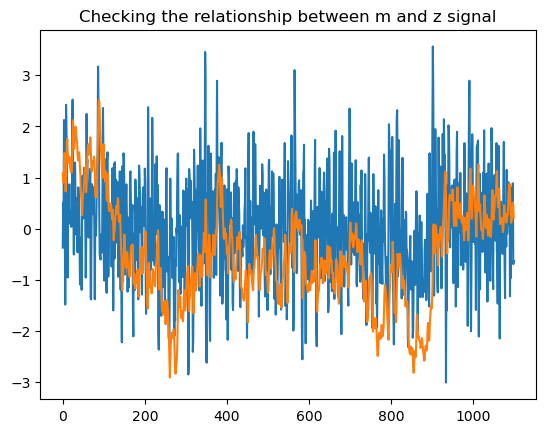

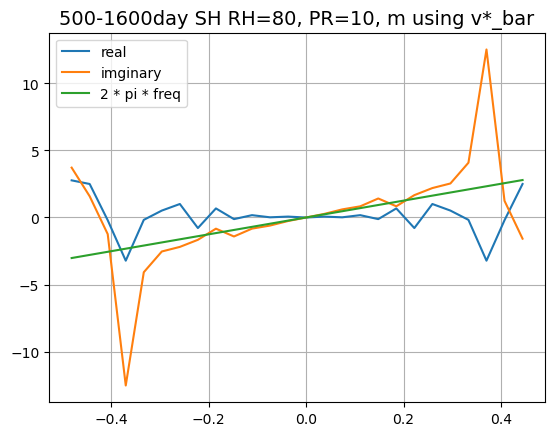

In [25]:
### do Southern Hemsiphere
# Before EOF, we need to normalize final_m_term
u_50   = u[:,:,:32,:] # dycore.getVar("grid_u_c_xyzt")
u_50_w_sm = np.zeros((((day,20,32,128))))
for i in range(1,32): # cy[0] and [-1] are np.nan
    u_50_w_sm[:,:,i,:] = u_50[:,:,i,:] * (cy[i])**0.5
u_50_w2_sm   = np.nanmean(u_50_w_sm[:,:,:,:], axis=(3))
u_50_new_sm  = np.reshape(u_50_w2_sm, (day, 20*32))
# print(u_50_new.shape)
###################################################


single_EOF_50 =  EOF((u_50_new_sm,), n_components=640, field="1D")
single_EOF_50.get()

z_paper_sm       = (single_EOF_50.PC[0,:])
EOF_try_sm       = (single_EOF_50.EOF[0,:])

z_paper_sm_std   = z_paper_sm.std()
z_paper_sm_final = z_paper_sm / z_paper_sm_std 

# plot for check whether I got correct EOF and PC, 
# so I project(do dot) EOF on PC to test if I would go back to original u wind.

EOF_sm_std = EOF_try_sm.std()
EOF_try_sm = EOF_try_sm * z_paper_sm_std 
EOF_back_sm = np.reshape(EOF_try_sm, (20,32))

f0v_star_sm = np.zeros(((day,20,32)))
for i in range(32):
    f0v_star_sm[:,:,i] = v_star[:,:,i] * f0[i]
f0v_star_sm_reshape = np.reshape(f0v_star_sm, (day,20*32))
f0v_star_sm_minus   = f0v_star_sm_reshape - np.nanmean(f0v_star_sm_reshape, axis=0)
m_right_sm = f0v_star_sm_reshape + vq_final_sm_reshape
m_right_final_sm = m_right_sm - np.nanmean(m_right_sm, axis=0)

m_sm = np.zeros(day)
for i in range(day):
    m_sm[i] = np.nansum(EOF_try_sm[2:-2]*m_right_final_sm[i,2:-2].T)

m_sm_std   = m_sm.std()
m_sm_final = m_sm / m_sm_std
plt.figure()
plt.title("Checking the relationship between m and z signal") 
plt.plot(m_sm_final)
plt.plot(z_paper_sm_final)
# Do not take the all time series to do FFT,
# there would be offset. So I'm gotta to take the small time interval to do FFT, 
# which are overlap (because after FFT, there would be a pulse at both ends of the spectrum space.
lg      = 27 # length of interval 
Z_sum   = np.zeros(lg, dtype = complex)
M_sum   = np.zeros(lg, dtype = complex)

for i in range(0 , len(z), lg):
    if i == 0:
        aa = i
        Z_sum += fft(z_paper_sm_final[0:aa+lg])  / len(z_paper_sm_final[0:aa+lg])     #要除以資料長度
        M_sum += fft(m_sm_final[0:aa+lg])  / len(m_sm_final[0:aa+lg])
    else:
        aa = int(i-10)   
        Z_sum += fft(z_paper_sm_final[aa:aa+lg]) / len(z_paper_sm_final[aa:aa+lg])    #要除以資料長度
        M_sum += fft(m_sm_final[aa:aa+lg]) / len(m_sm_final[aa:aa+lg])
        # print(np.nanmin(Z_sum))

# print((len(Z) / lg))
Z = Z_sum / (len(z_paper_sm_final) / lg)
M = M_sum / (len(m_sm_final) / lg)
# print(Z_final)

freq   = fftfreq(Z.shape[0])
idx    = np.argsort(freq)

M_star = np.conjugate(M)
Z_star = np.conjugate(Z)

final  = (Z_star * M) / (Z_star * Z)

kk     = -1  #int(lg)
ll     = 0   #int(lg/2-2)
plt.figure(dpi=100.)
plt.title("500-1600day SH RH=80, PR=10, m using v*_bar", fontsize=14)
plt.plot(freq[idx][ll:kk], (final[idx][ll:kk]).real / np.pi, label="real")
plt.plot(freq[idx][ll:kk], (final[idx][ll:kk]).imag / np.pi, label="imginary")
plt.plot(freq[idx][ll:kk], (freq[idx][ll:kk]) * 2 * np.pi, label="2 * pi * freq")

# plt.xlim([-0.01, 0.25])
# plt.ylim([-0.05,1.75])
plt.grid()
plt.legend()
# plt.savefig(r"paper1_fig/eq(7.66a)_fig/RH50_PR10//800day_SH_v*_cross_spectrum.png", bbox_inches='tight', dpi=600.)
plt.show()

In [26]:
### do NM
### edited for EOF, changing the dimension to (day, 20, 64) to do baroclinc annular mode

q2_nm = np.zeros(((day,20,32)))
for i in range(1,20-1):
    q2_nm[:,i,:] = (MHF_f[:,i+1,32:] - MHF_f[:,i-1,32:])  / np.nanmean(z[:,i+1,32:,:]-z[:,i-1,32:,:], axis=(0,2)) 
MHF_f_new = np.zeros(((day,22,64)))

for i in range(day):
    for j in range(32):
        fe             = interp1d(np.linspace(0,20,20), MHF_f[i,:,j+32],  fill_value='extrapolate')
        MHF_f_new[i,:,j] = fe(np.linspace(-1,21,22))

# q2[ 0,:] = (MHF_f_new[ 2,:] - MHF_f_new[ 0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(0,2)) 
# q2[19,:] = (MHF_f_new[21,:] - MHF_f_new[19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(0,2)) 
#
# q2[q2 == inf] = np.nan
vq_final_nm = q2_nm + dmdy[:,:,32:]
vq_final_nm_reshape = np.reshape(vq_final_nm,(day,20*32))

vq_final_nm_mean  = np.nanmean(vq_final_nm_reshape, axis=0)
vq_final_nm_minus = vq_final_nm_reshape - vq_final_nm_mean
#


# MHF_new = np.zeros(((day,22,64)))

# for i in range(day):
#     for j in range(64):
#         fe             = interp1d(np.linspace(0,20,20), MHF[i,:,j],  fill_value='extrapolate')
#         MHF_new[i,:,j] = fe(np.linspace(-1,21,22))

VHF_nm = np.zeros(((day,20,32))) # vertical heat flux
for i in range(1,20-1):
    VHF_nm[:,i,:] = (MHF[:,i+1,32:] - MHF[:,i-1,32:])  / np.nanmean(z[:,i+1,32:,:]-z[:,i-1,32:,:], axis=(2)) 
# VHF[ :,0,:] = (MHF_new[ :,2,:] - MHF_new[ :,0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(2)) 
# VHF[:,19,:] = (MHF_new[:,21,:] - MHF_new[:,19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(2)) 

v_star_nm = np.nanmean(v[:,:,32:,:], axis=3) - VHF_nm
print("over")

over


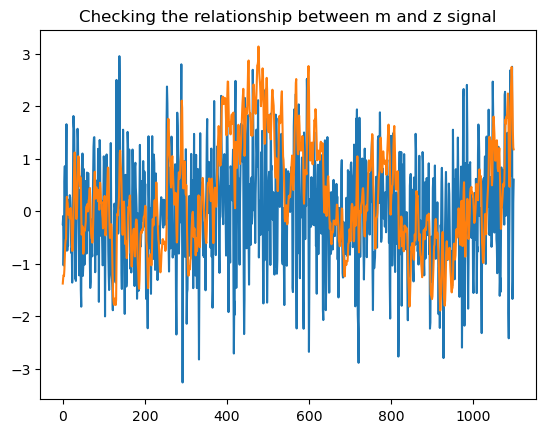

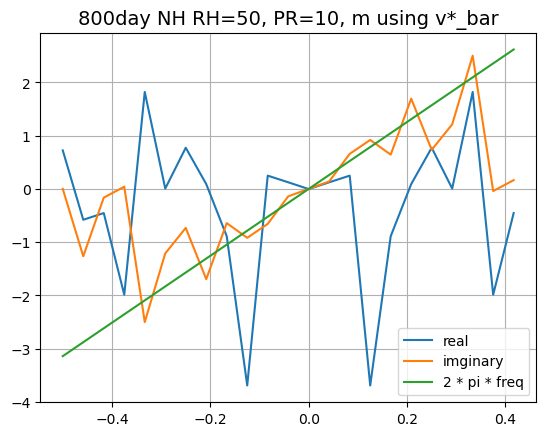

In [40]:
### do Northen Hemsiphere
# Before EOF, we need to normalize final_m_term
u_50   = u[:,:,:,:] # dycore.getVar("grid_u_c_xyzt")
u_50_w_nm = np.zeros((((day,20,32,128))))
for i in range(1,32): # cy[0] and [-1] are np.nan
    u_50_w_nm[:,:,i,:] = u_50[:,:,i+32,:] * (cy[i])**0.5
u_50_w2_nm   = np.nanmean(u_50_w_nm[:,:,:,:], axis=(3))
u_50_new_nm  = np.reshape(u_50_w2_nm, (day, 20*32))
# print(u_50_new.shape)
###################################################


single_EOF_50 =  EOF((u_50_new_nm,), n_components=640, field="1D")
single_EOF_50.get()

z_paper_nm       = (single_EOF_50.PC[0,:])
EOF_try_nm       = (single_EOF_50.EOF[0,:])

z_paper_nm_std   = z_paper_nm.std()
z_paper_nm_final = z_paper_nm / z_paper_nm_std 

# plot for check whether I got correct EOF and PC, 
# so I project(do dot) EOF on PC to test if I would go back to original u wind.

EOF_nm_std = EOF_try_nm.std()
EOF_try_nm = EOF_try_nm * z_paper_nm_std 
EOF_back_nm = np.reshape(EOF_try_nm, (20,32))

f0v_star_nm = np.zeros(((day,20,32)))
for i in range(32):
    f0v_star_nm[:,:,i] = v_star[:,:,i+32] * f0[i+32]
f0v_star_nm_reshape = np.reshape(f0v_star_nm, (day,20*32))
f0v_star_nm_minus   = f0v_star_nm_reshape - np.nanmean(f0v_star_nm_reshape, axis=0)
m_right_nm = f0v_star_nm_reshape + vq_final_nm_reshape
m_right_final_nm = m_right_nm - np.nanmean(m_right_nm, axis=0)

m_nm = np.zeros(day)
for i in range(day):
    m_nm[i] = np.nansum(EOF_try_nm[2:-2]*m_right_final_nm[i,2:-2].T)

m_nm_std   = m_nm.std()
m_nm_final = m_nm / m_nm_std
plt.figure()
plt.title("Checking the relationship between m and z signal") 
plt.plot(m_nm_final)
plt.plot(z_paper_nm_final)
# Do not take the all time series to do FFT,
# there would be offset. So I'm gotta to take the small time interval to do FFT, 
# which are overlap (because after FFT, there would be a pulse at both ends of the spectrum space.
lg      = 24 # length of interval 
Z_sum   = np.zeros(lg, dtype = complex)
M_sum   = np.zeros(lg, dtype = complex)

for i in range(0 , len(z), lg):
    if i == 0:
        aa = i
        Z_sum += fft(z_paper_nm_final[0:aa+lg])  / len(z_paper_nm_final[0:aa+lg])     #要除以資料長度
        M_sum += fft(m_nm_final[0:aa+lg])  / len(m_nm_final[0:aa+lg])
    else:
        aa = int(i-10)   
        Z_sum += fft(z_paper_nm_final[aa:aa+lg]) / len(z_paper_nm_final[aa:aa+lg])    #要除以資料長度
        M_sum += fft(m_nm_final[aa:aa+lg]) / len(m_nm_final[aa:aa+lg])
        # print(np.nanmin(Z_sum))

# print((len(Z) / lg))
Z = Z_sum / (len(z_paper_nm_final) / lg)
M = M_sum / (len(m_nm_final) / lg)
# print(Z_final)

freq   = fftfreq(Z.shape[0])
idx    = np.argsort(freq)

M_star = np.conjugate(M)
Z_star = np.conjugate(Z)

final  = (Z_star * M) / (Z_star * Z)

kk     = -1  #int(lg)
ll     = 0   #int(lg/2-2)
plt.figure(dpi=100.)
plt.title("800day NH RH=50, PR=10, m using v*_bar", fontsize=14)
plt.plot(freq[idx][ll:kk], (final[idx][ll:kk]).real / np.pi, label="real")
plt.plot(freq[idx][ll:kk], (final[idx][ll:kk]).imag / np.pi, label="imginary")
plt.plot(freq[idx][ll:kk], (freq[idx][ll:kk]) * 2 * np.pi, label="2 * pi * freq")

# plt.xlim([-0.25, 0.25])
# plt.ylim([-3,3])
plt.grid()
plt.legend()
# plt.savefig(r"paper1_fig/eq(7.66a)_fig/RH50_PR10//800day_NH_v*_cross_spectrum.png", bbox_inches='tight', dpi=600.)
plt.show()